# Non Gaussian Setup On Real Data

In [65]:
from src.dataset import FinDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, jarque_bera
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf


In [46]:
finData = FinDataset()
data = finData._get_data_yfinance()


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


## Plot of returns and prices

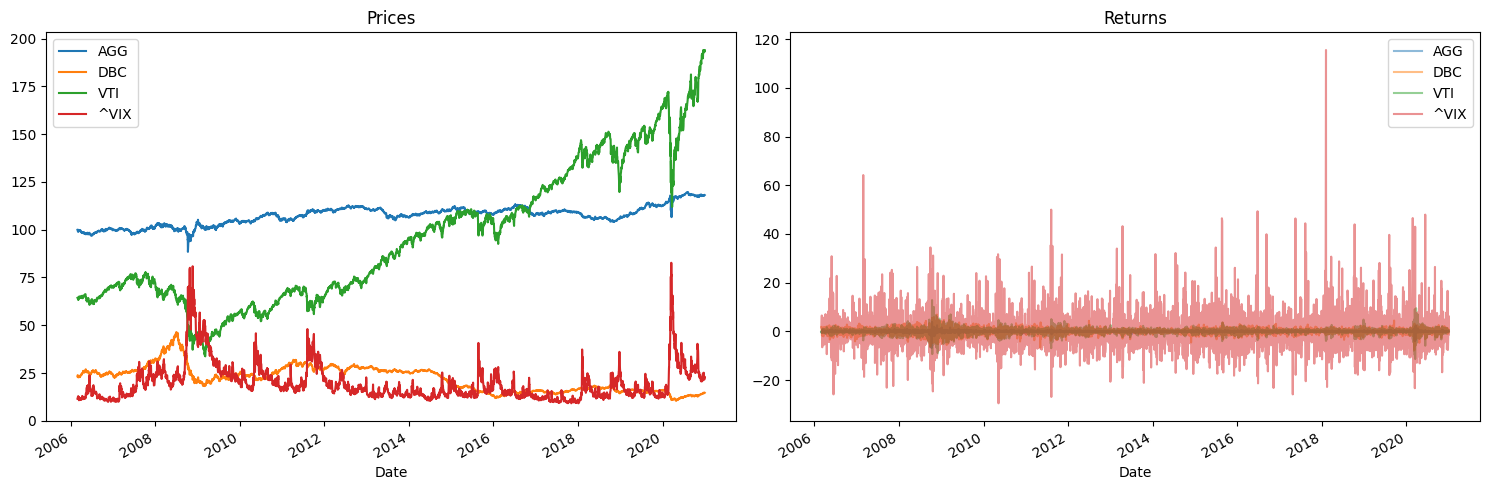

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

data['prices'].plot(ax=axes[0], title='Prices')
data['returns'].plot(ax=axes[1], alpha=0.5, title='Returns')

plt.tight_layout()
plt.show()


## Plot of distributions (daily and monthly) + Jarque-Bera p-value

### All tests reject the null hyphothesis of gaussian distributions

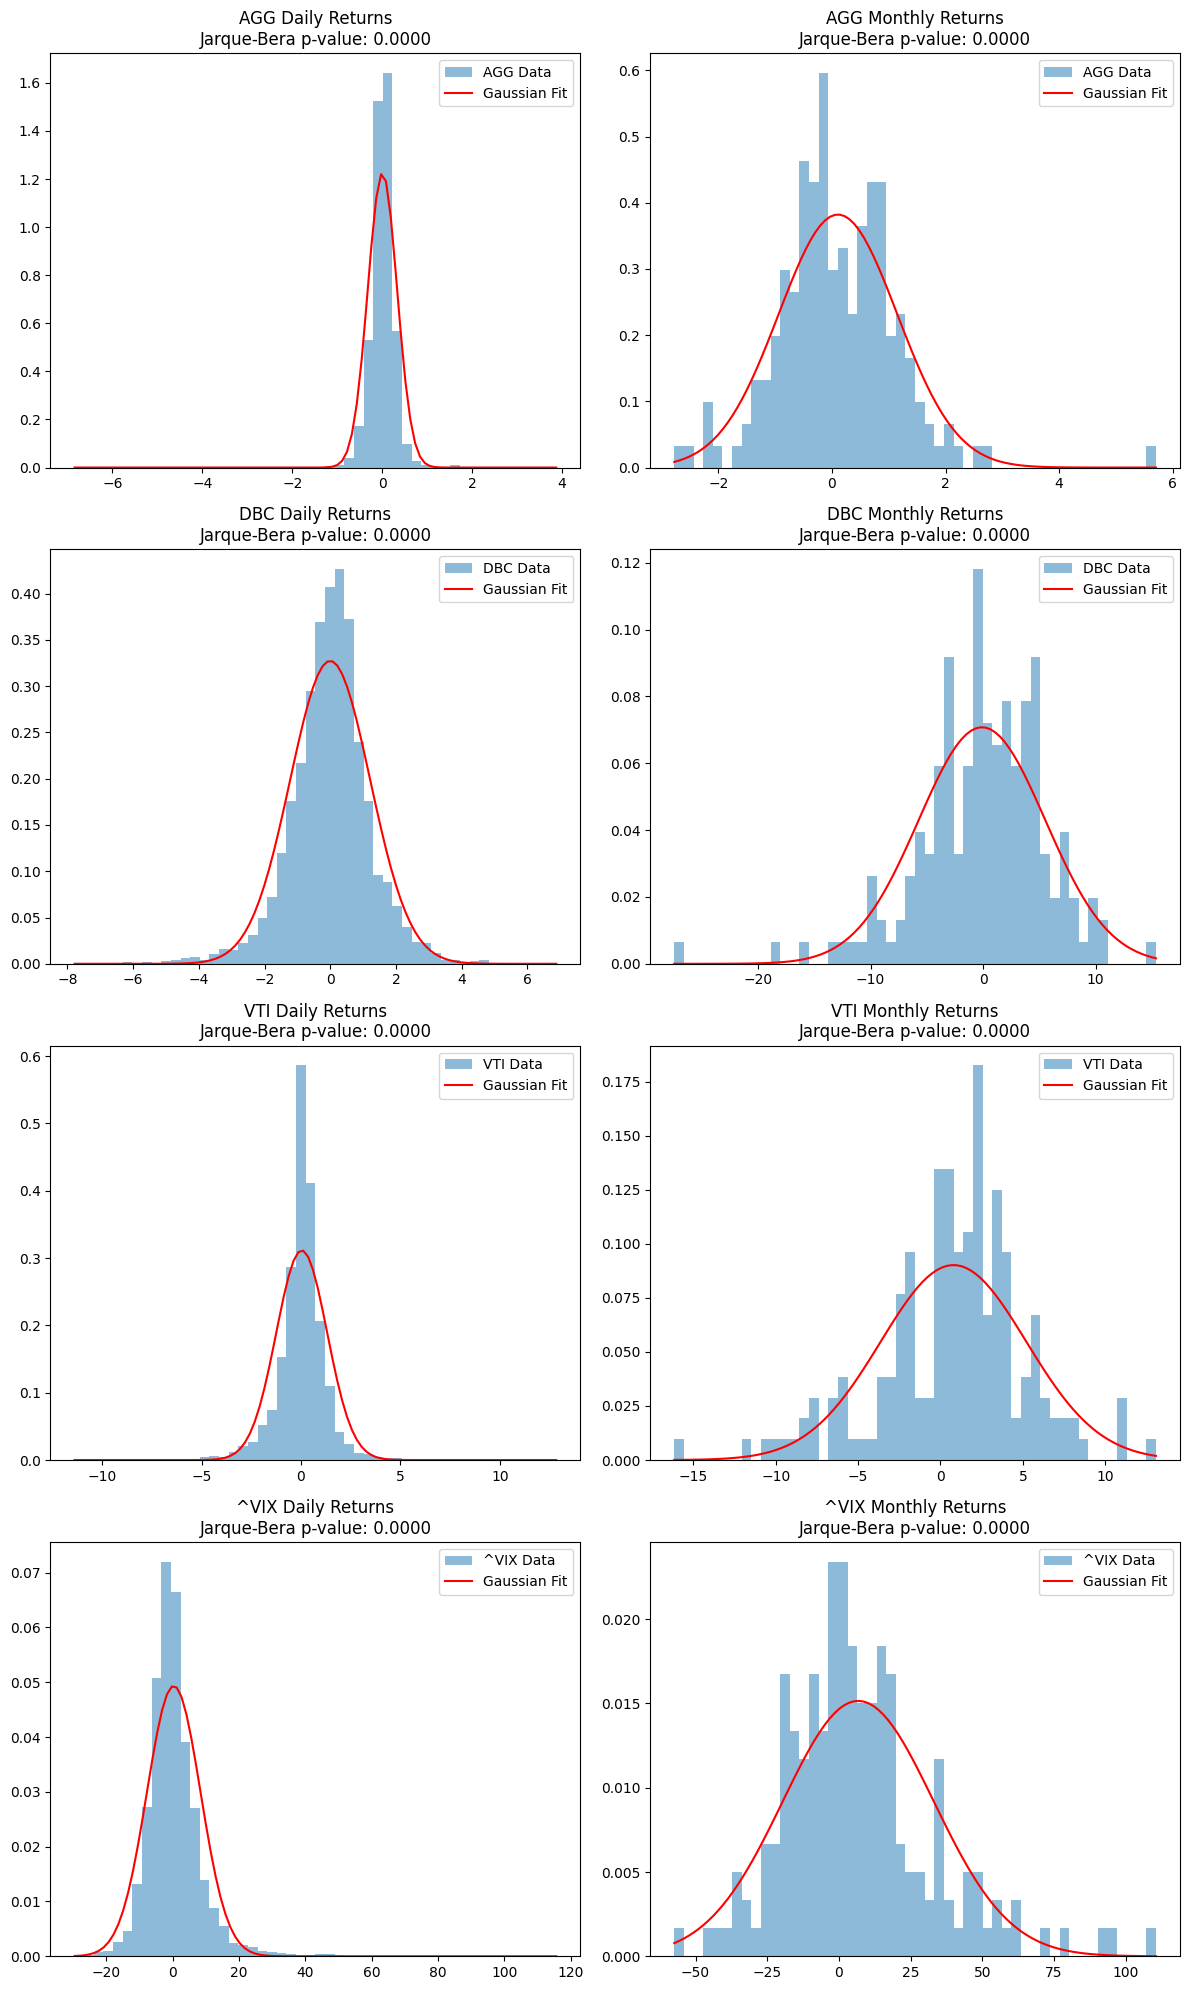

(None, None)

In [51]:
fig, axes = plt.subplots(len(data['returns'].columns), 2, figsize=(12, 5 * len(data['returns'].columns)))
for i, asset in enumerate(data['returns'].columns):
    for freq, col in zip(['D', 'M'], axes[i]):
        data_resampled = data['returns'][asset] if freq == 'D' else data['returns'][asset].resample('M').sum()
        mean, std = data_resampled.mean(), data_resampled.std()
        x = np.linspace(data_resampled.min(), data_resampled.max(), 100)
        jb_stat, p_value = jarque_bera(data_resampled.dropna())
        col.hist(data_resampled, bins=50, density=True, alpha=0.5, label=f'{asset} Data')
        col.plot(x, norm.pdf(x, mean, std), color='red', label='Gaussian Fit')
        col.set_title(f'{asset} {"Daily" if freq == "D" else "Monthly"} Returns\nJarque-Bera p-value: {p_value:.4f}')
        col.legend()
plt.tight_layout(), plt.show()

## Generating the Gaussian Multivariate from Empirical Estimation

1. **Gaussian Distribution and Jarque-Bera Test**  
   - Plot the Gaussian distribution.
   - Perform the Jarque-Bera test to assess normality.

2. **Autocorrelation Analysis (ACF)**  
   - Plot the autocorrelation function (ACF) for both squared returns and returns.
   - In the Gaussian case, there should be no autocorrelation (ACF close to 0) for both squared returns and regular returns.


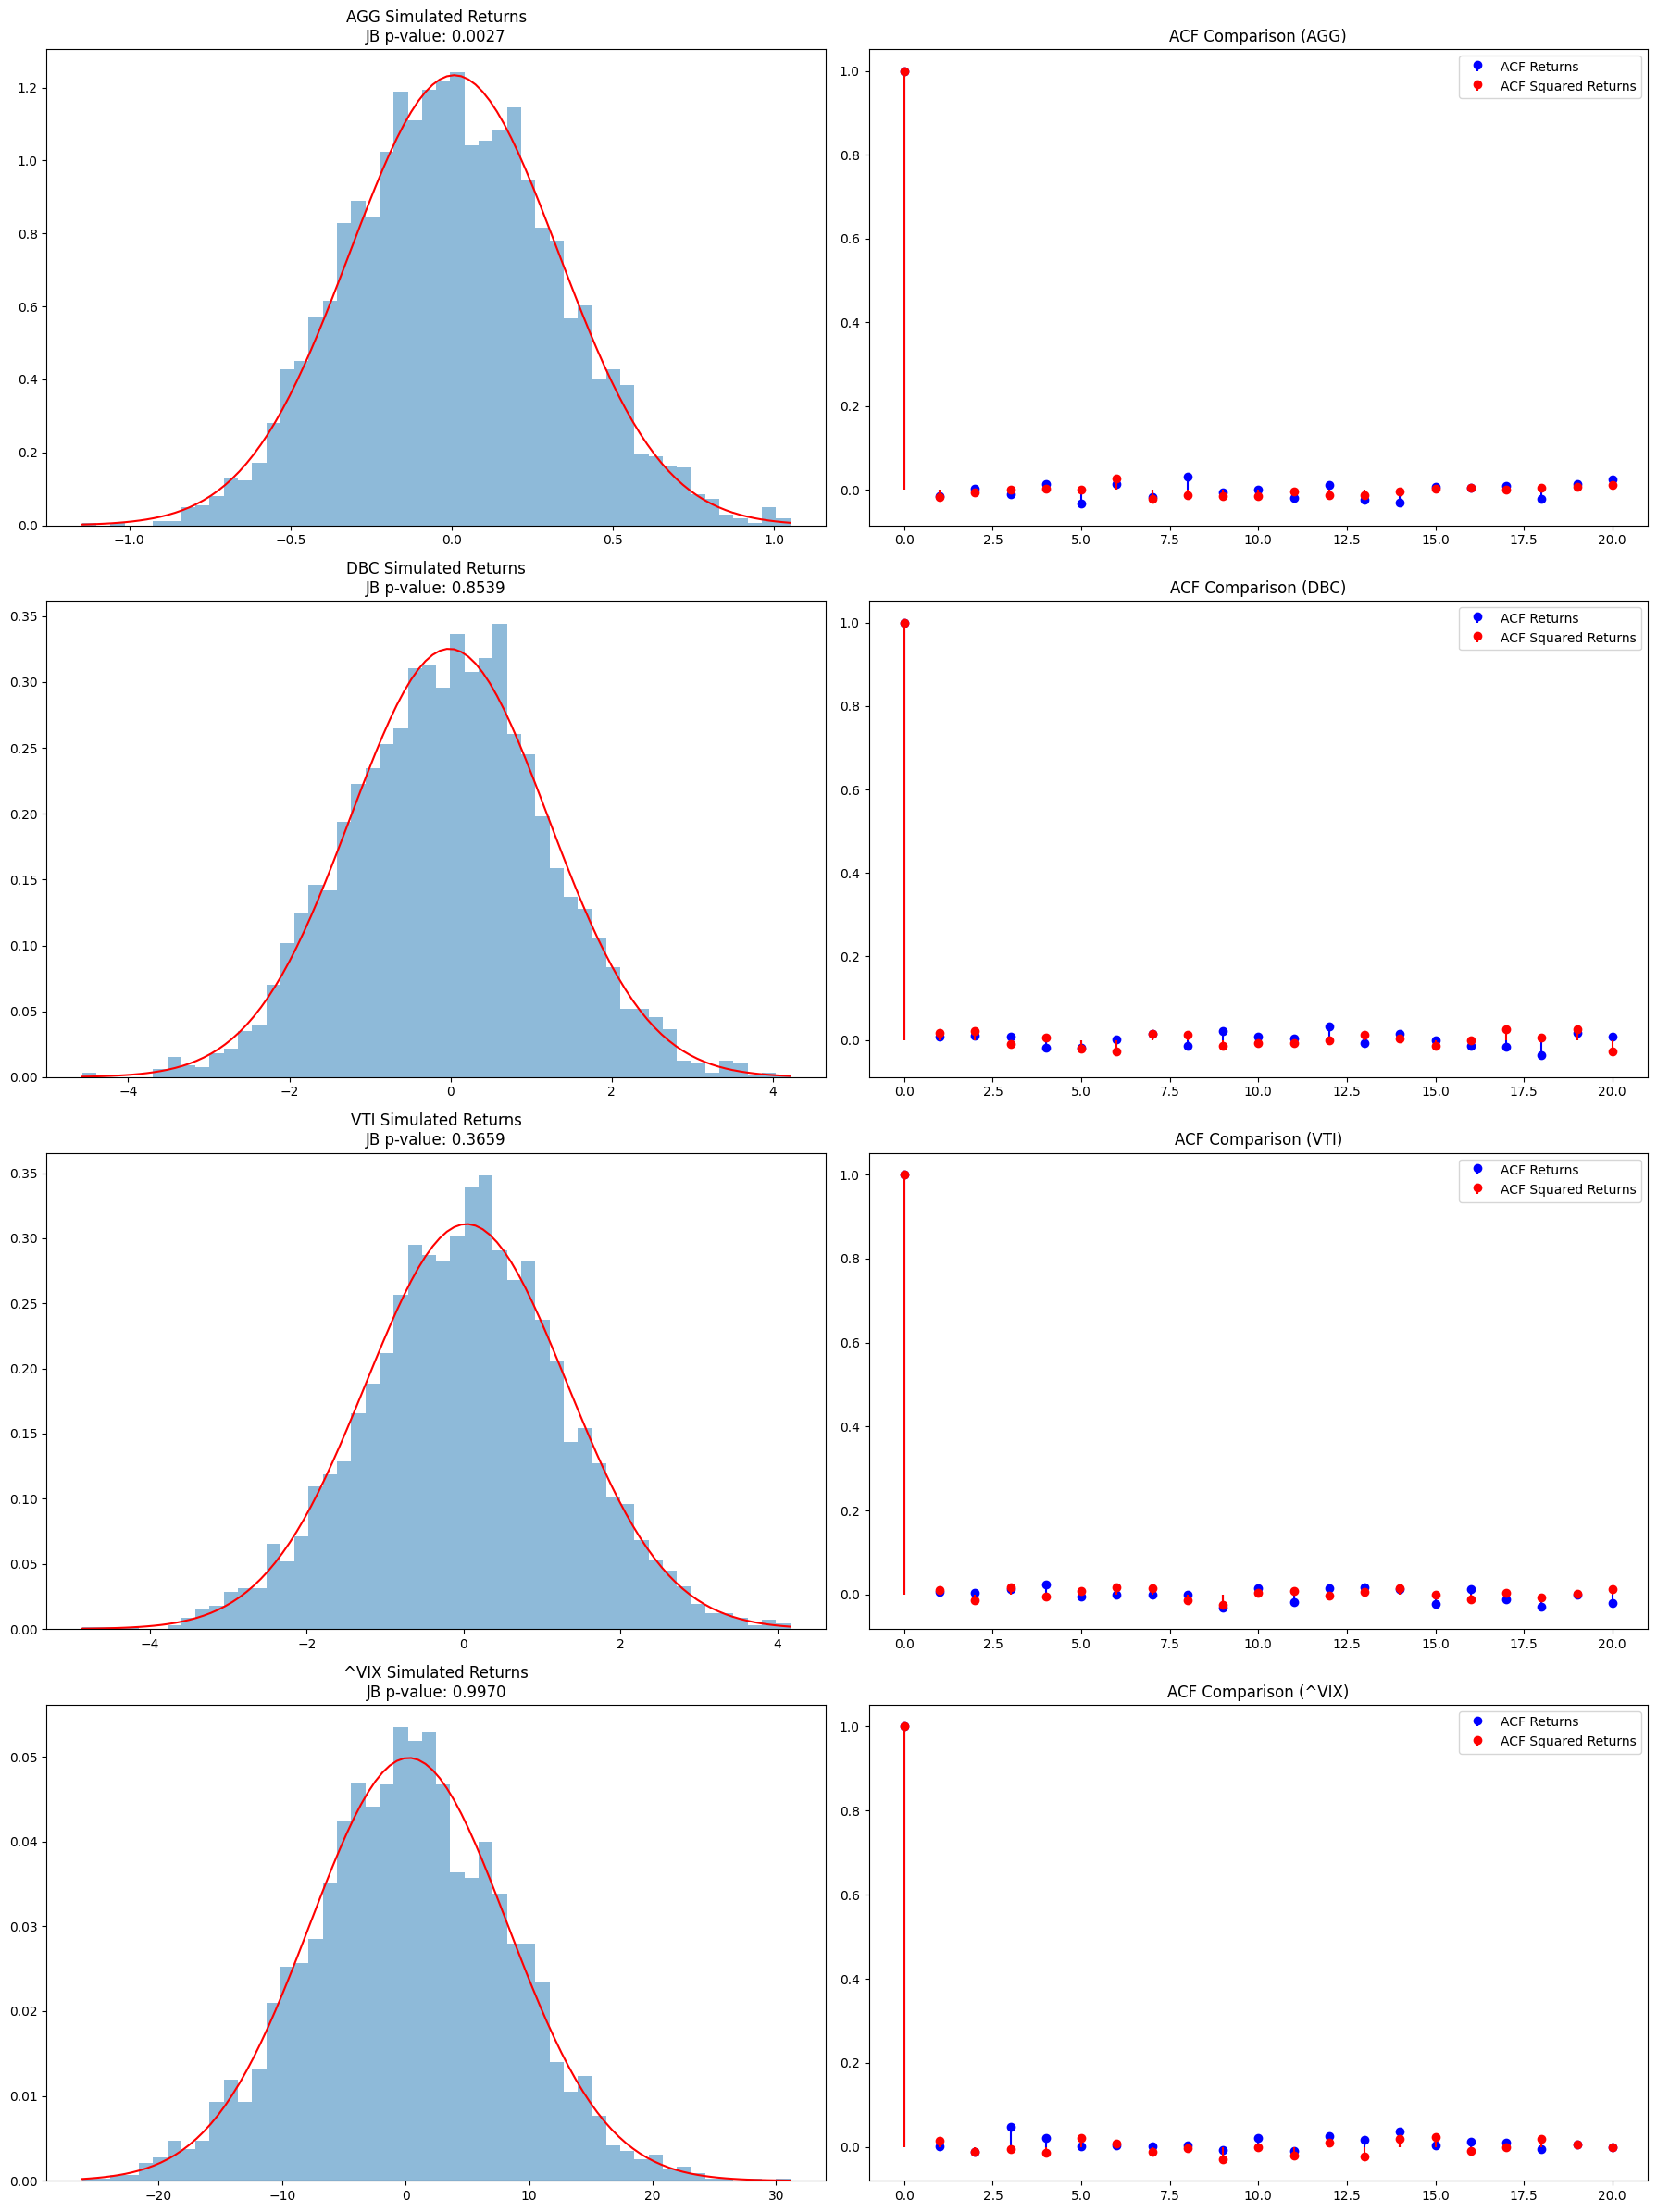

In [69]:
returns = data['returns']
mean_vector = returns.mean()
cov_matrix = returns.cov()
simulated_data = np.random.multivariate_normal(mean_vector, cov_matrix, size=len(returns))
simulated_data = simulated_data.T

fig, axes = plt.subplots(len(returns.columns), 2, figsize=(18, 6 * len(returns.columns)))
for i, asset in enumerate(returns.columns):
    simulated_returns = simulated_data[i]
    lags = 20
    acf_rt = acf(simulated_returns, nlags=lags, fft=True)
    acf_rt2 = acf(simulated_returns**2, nlags=lags, fft=True)
    jb_stat, p_value = jarque_bera(simulated_returns)
    axes[i, 0].hist(simulated_returns, bins=50, density=True, alpha=0.5, label='Simulated Data')
    x = np.linspace(simulated_returns.min(), simulated_returns.max(), 100)
    axes[i, 0].plot(x, norm.pdf(x, simulated_returns.mean(), simulated_returns.std()), color='red', label='Gaussian Fit')
    axes[i, 0].set_title(f'{asset} Simulated Returns\nJB p-value: {p_value:.4f}')
    axes[i, 1].stem(range(lags + 1), acf_rt, basefmt=" ", linefmt='blue', markerfmt='bo', use_line_collection=True, label='ACF Returns')
    axes[i, 1].stem(range(lags + 1), acf_rt2, basefmt=" ", linefmt='red', markerfmt='ro', use_line_collection=True, label='ACF Squared Returns')
    axes[i, 1].set_title(f'ACF Comparison ({asset})')
    axes[i, 1].legend()
plt.tight_layout()
plt.show()


## ACF of Squared Returns and Returns for Real Returns

1. **Volatility Clustering in Squared Returns**  
   - Empirically, we observe what is known as **volatility clustering**.  
     This means that \( r_t^2 \) (squared returns) is correlated with its past values.  
     In other words, large movements in returns are often followed by large movements, and small movements by small movements, regardless of the direction of the movement.

2. **Lack of Correlation in Returns**  
   - The actual returns (\( r_t \)) themselves, however, are not correlated.  
     This suggests that the sequence of returns does not exhibit linear dependence over time, but their variance does.

3. **Evidence Against Gaussian Modeling**  
   - The observed properties of returns—volatility clustering and the lack of linear correlation in \( r_t \)—indicate that the Gaussian setting is not appropriate for modeling financial returns.  
     A Gaussian model assumes constant variance and no higher-order dependencies, which contradicts these empirical findings.


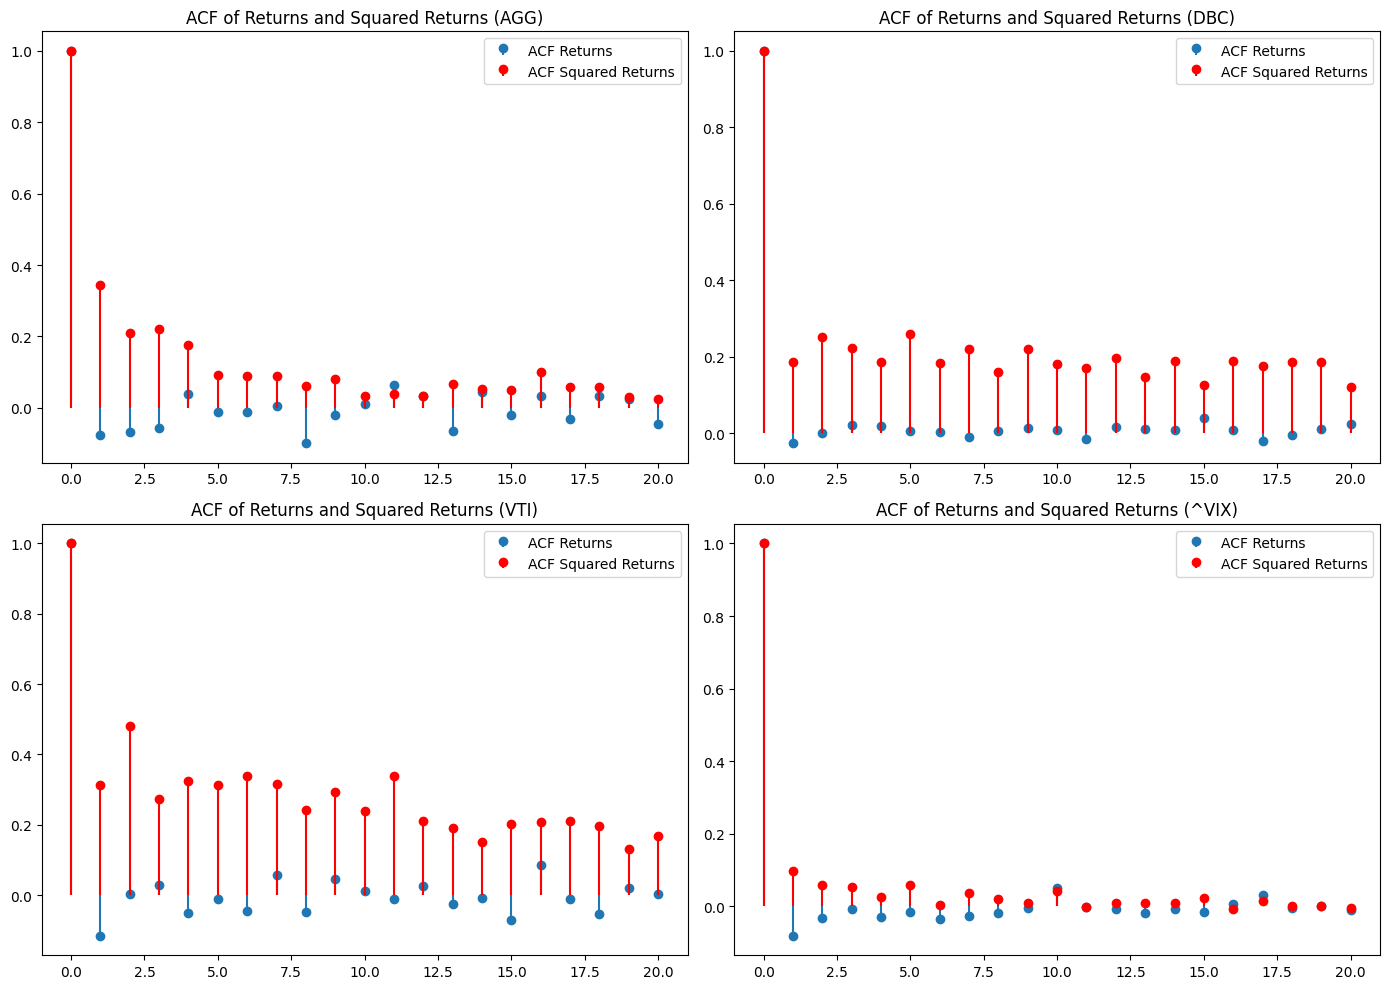

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Création d'une grille 2x2

assets = returns.columns[:4]  # Sélection des 4 premiers actifs

for i, asset in enumerate(assets):
    row, col = divmod(i, 2)  # Calcul de la position dans la grille
    asset_returns = returns[asset].dropna()
    acf_rt = acf(asset_returns, nlags=20, fft=True)
    acf_rt2 = acf(asset_returns**2, nlags=20, fft=True)
    
    axes[row, col].stem(range(21), acf_rt, basefmt=" ", use_line_collection=True, label='ACF Returns')
    axes[row, col].stem(range(21), acf_rt2, basefmt=" ", linefmt='r-', markerfmt='ro', use_line_collection=True, label='ACF Squared Returns')
    axes[row, col].set_title(f'ACF of Returns and Squared Returns ({asset})')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

### Leverage Effect

#### Overview
The leverage effect captures the correlation between past returns and future volatility. This phenomenon is often negative and decays over time in real-world financial data.

#### Comparison: Gaussian Setup vs. Real-Life Setup
- **Gaussian Setup:**
  - Simulated data using a Gaussian multivariate distribution shows no leverage effect.
  - Correlations between past returns and squared future returns remain close to zero.

- **Real-Life Setup:**
  - Real financial data reveals a strong negative leverage effect.
  - The correlation decreases exponentially with increasing lag.

#### Observations
- The Gaussian setup demonstrates the absence of any leverage effect, as expected from its statistical properties.
- The real-life setup highlights the pronounced presence of leverage, consistent with empirical findings in financial markets.
- For the **VIX (Volatility Index):**
  - The leverage effect is not observed due to the unique nature of the VIX as a volatility measure, which behaves differently compared to typical financial assets.


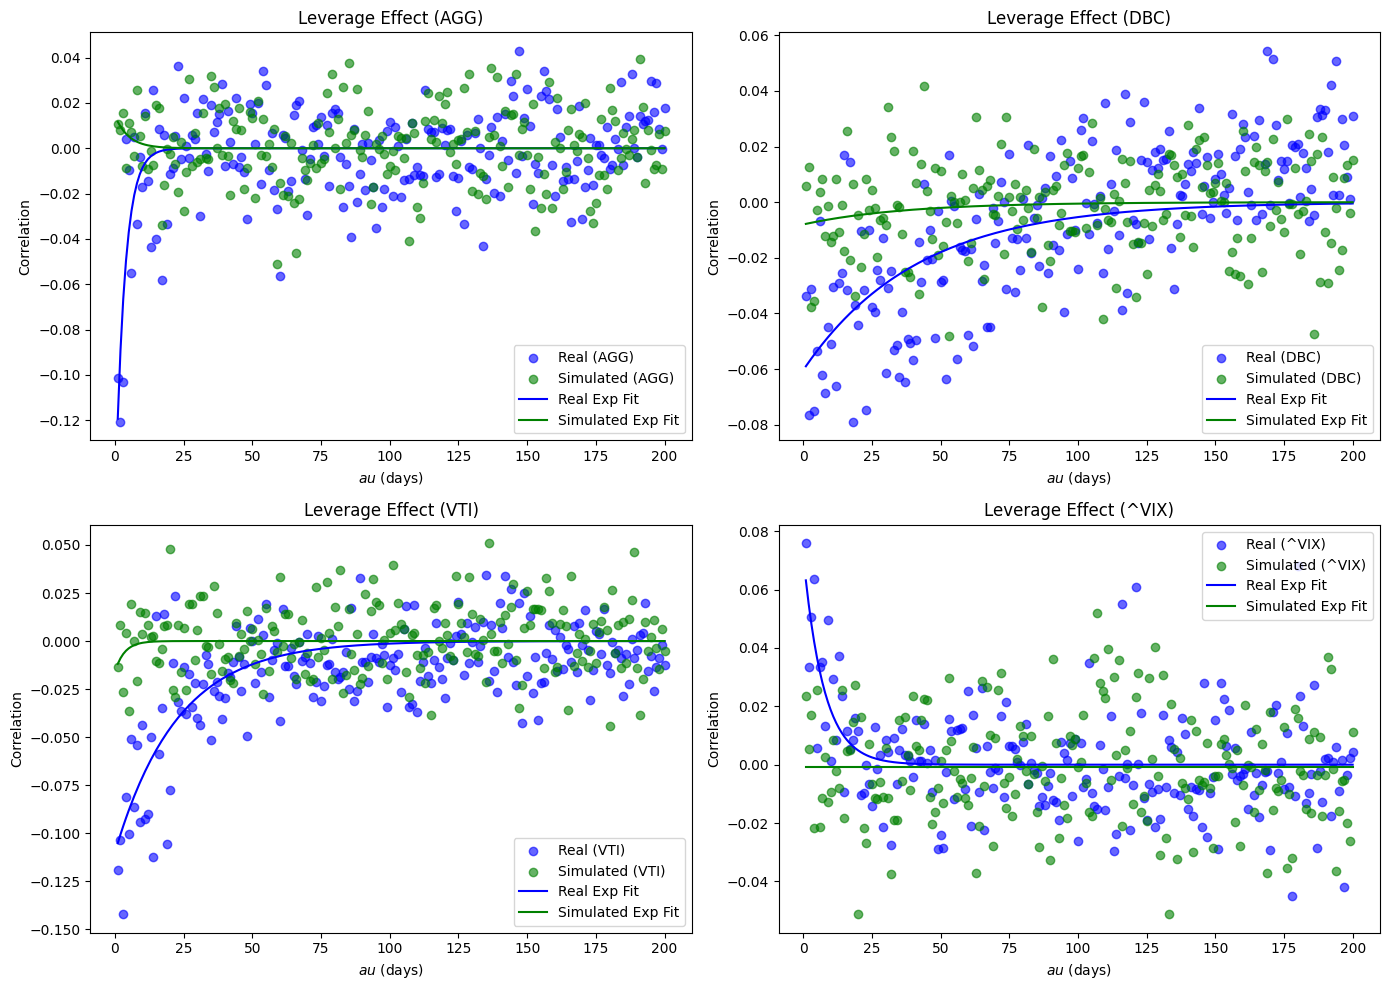

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
assets = returns.columns[:4]
for idx, asset in enumerate(assets):
    row, col = divmod(idx, 2)
    real_returns = returns[asset].dropna()
    synthetic_returns = simulated_data[idx]
    lags = np.arange(1, 201)
    real_leverage = [real_returns.shift(1).corr((real_returns ** 2).shift(-lag)) for lag in lags]
    synthetic_leverage = [np.corrcoef(synthetic_returns[:-lag], synthetic_returns[lag:]**2)[0, 1] for lag in lags]
    params_real, _ = curve_fit(exponential_decay, lags, real_leverage, p0=(1, 50))
    params_synthetic, _ = curve_fit(exponential_decay, lags, synthetic_leverage, p0=(1, 50))
    axes[row, col].scatter(lags, real_leverage, label=f'Real ({asset})', color='blue', alpha=0.6)
    axes[row, col].scatter(lags, synthetic_leverage, label=f'Simulated ({asset})', color='green', alpha=0.6)
    axes[row, col].plot(lags, exponential_decay(lags, *params_real), label='Real Exp Fit', color='blue')
    axes[row, col].plot(lags, exponential_decay(lags, *params_synthetic), label='Simulated Exp Fit', color='green')
    axes[row, col].set_title(f'Leverage Effect ({asset})')
    axes[row, col].set_xlabel('$\tau$ (days)')
    axes[row, col].set_ylabel('Correlation')
    axes[row, col].legend()
plt.tight_layout()
plt.show()